In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

DB = mysql.connector.connect(host = "localhost", username = "root", password = "Jerry@161102", database = "ecommerce")

cur = DB.cursor()

### QUERIES

#### 1. List all unique cities where customers are located.

In [2]:
query = """SELECT DISTINCT(customer_city) FROM customers"""
cur.execute(query)
data = cur.fetchall()
data
df=pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


### 2. Count the number of orders placed in 2017.

In [3]:
query = """SELECT COUNT(order_id) FROM orders WHERE year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
" Count the number of orders placed in 2017 :", data[0][0]

(' Count the number of orders placed in 2017 :', 180404)

### 3. Find the total sales per category.

In [4]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,16215637.12
1,FURNITURE DECORATION,45765644.54
2,TELEPHONY,15580225.62
3,BED TABLE BATH,54801717.47
4,AUTOMOTIVE,27273418.60
...,...,...
69,CDS MUSIC DVDS,38381.76
70,LA CUISINE,93232.96
71,FASHION CHILDREN'S CLOTHING,25141.44
72,PC GAMER,69581.76


### 4. Calculate the percentage of orders that were paid in installments.

In [5]:
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

### 5. Count the number of customers from each state. 

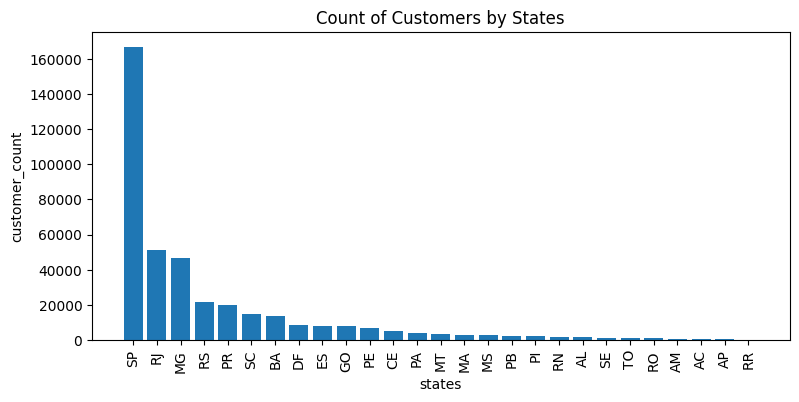

In [6]:
query = """ select customer_state, count(customer_id)
from customers group by customer_state"""
cur.execute(query)

data = cur.fetchall()
data
df = pd.DataFrame(data, columns =["state","customer_count"])
df
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (9,4))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

### 6. Calculate the number of orders per month in 2018.

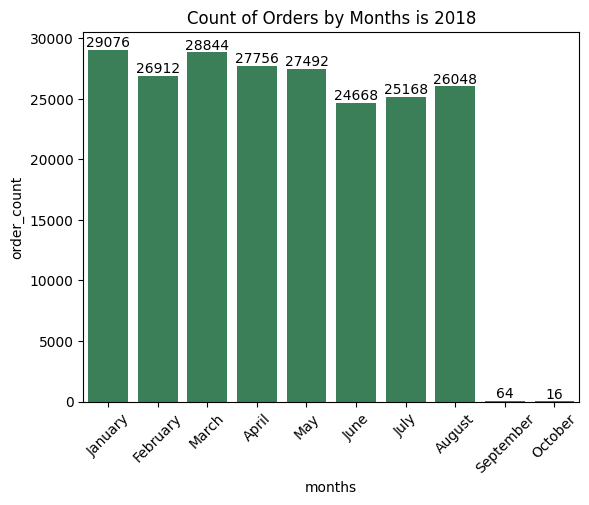

In [7]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "seagreen")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

### 7. Find the average number of products per order, grouped by customer city.

In [8]:
query = """ with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as count_order
from orders join order_items on orders.order_id = order_items.order_id 
group by orders.order_id, orders.customer_id) 
select customers.customer_city, round(avg(count_per_order.count_order),2) as avrage_orders from customers 
join count_per_order on customers.customer_id = count_per_order.customer_id 
group by customers.customer_city order by avrage_orders desc; """
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns = ["customer_city","average products/order"])
df.head(10)

,customer_city,average products/order
0,padre carvalho,56.00
1,celso ramos,52.00
2,datas,48.00
3,candido godoi,48.00
4,matias olimpio,40.00
5,cidelandia,32.00
6,curralinho,32.00
7,picarra,32.00
8,morro de sao paulo,32.00
9,teixeira soares,32.00


### 8. Calculate the percentage of total revenue contributed by each product category.

In [14]:
query = """ select upper(products.product_category) category, 
round((sum(payments.payment_value) / (select sum(payment_value) from payments))*100,2) sales_perstage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_perstage desc;
"""

cur.execute(query)

data = cur.fetchall()
data
df=pd.DataFrame(data,columns = [" Product_category "," % of revenue "])
df.head(10)

,Product_category,% of revenue
0,BED TABLE BATH,85.58
1,HEALTH BEAUTY,82.82
2,COMPUTER ACCESSORIES,79.22
3,FURNITURE DECORATION,71.47
4,WATCHES PRESENT,71.42
5,SPORT LEISURE,69.57
6,HOUSEWARES,54.71
7,AUTOMOTIVE,42.59
8,GARDEN TOOLS,41.89
9,COOL STUFF,38.96


### 9. Identify the correlation between product price and the number of times a product has been purchased.

In [17]:
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


### 10. Calculate the total revenue generated by each seller, and rank them by revenue.

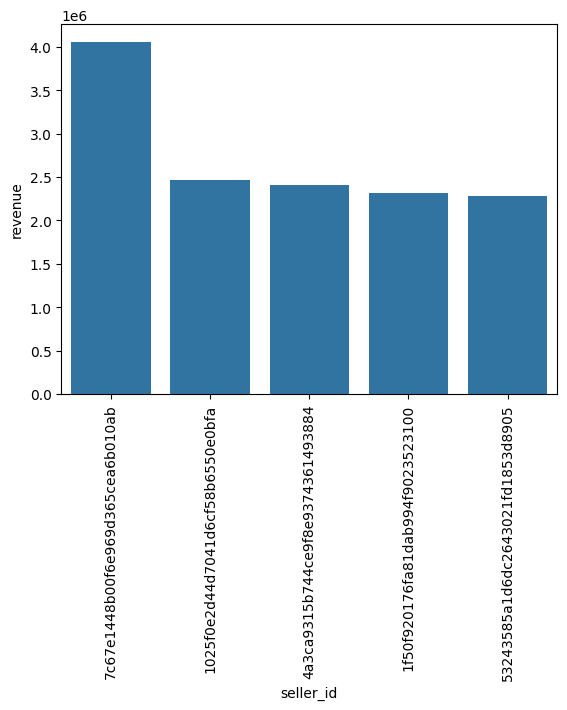

In [21]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

### 11. Calculate the moving average of order values for each customer over their order history.

In [22]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,)
df


,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
1662171,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1662172,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1662173,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1662174,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


### 12. Calculate the cumulative sales per month for each year.

In [23]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df



,0,1,2,3
0,2016,9,4035.84,4.035840e+03
1,2016,10,945447.68,9.494835e+05
2,2016,12,313.92,9.497974e+05
3,2017,1,2215808.64,3.165606e+06
4,2017,2,4670528.15,7.836134e+06
5,2017,3,7197817.59,1.503395e+07
6,2017,4,6684608.47,2.171856e+07
7,2017,5,9486701.12,3.120526e+07
8,2017,6,8180422.09,3.938568e+07
9,2017,7,9478126.71,4.886381e+07


### 13. Calculate the year-over-year growth rate of total sales.

In [24]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


### 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [25]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

### 15. Identify the top 3 customers who spent the most money in each year.

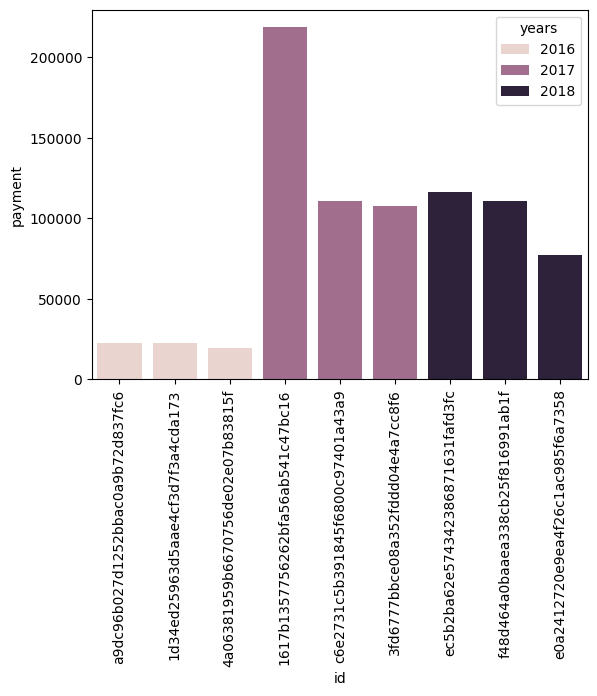

In [26]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()